In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import keras_ocr

In [4]:
# pylint:disable=too-many-locals
def warpBox(image,
            box,
            target_height=None,
            target_width=None,
            margin=0,
            cval=None,
            return_transform=False,
            skip_rotate=False):
    """Warp a boxed region in an image given by a set of four points into
    a rectangle with a specified width and height. Useful for taking crops
    of distorted or rotated text.
    Args:
        image: The image from which to take the box
        box: A list of four points starting in the top left
            corner and moving clockwise.
        target_height: The height of the output rectangle
        target_width: The width of the output rectangle
        return_transform: Whether to return the transformation
            matrix with the image.
    """
    if cval is None:
        cval = (0, 0, 0) if len(image.shape) == 3 else 0
    if not skip_rotate:
        box, _ = keras_ocr.tools.get_rotated_box(box)
    w, h = keras_ocr.tools.get_rotated_width_height(box)
    margin = h*margin
    assert (
        (target_width is None and target_height is None)
        or (target_width is not None and target_height is not None)), \
            'Either both or neither of target width and height must be provided.'
    if target_width is None and target_height is None:
        target_width = w
        target_height = h
    scale = min(target_width / w, target_height / h)
    M = cv2.getPerspectiveTransform(src=box,
                                    dst=np.array([[margin, margin], [scale * w - margin, margin],
                                                  [scale * w - margin, scale * h - margin],
                                                  [margin, scale * h - margin]]).astype('float32'))
    crop = cv2.warpPerspective(image, M, dsize=(int(scale * w), int(scale * h)))
    target_shape = (target_height, target_width, 3) if len(image.shape) == 3 else (target_height,
                                                                                   target_width)
    full = (np.zeros(target_shape) + cval).astype('uint8')
    full[:crop.shape[0], :crop.shape[1]] = crop
    if return_transform:
        return full, M
    return full


In [14]:
def calc_box(img_path, detector):
    low_text_options = [0.3, 0.2, 0.1, 0.05, 0.01, 0.001, 0]
    low_text_index = 0
    img = keras_ocr.tools.read(img_path)
    image = keras_ocr.detection.compute_input(img)
    bboxes = keras_ocr.detection.getBoxes(detector.model.predict(np.array([image])), 
                                         text_threshold=0.9)

    while bboxes[0].shape[0]>1:
        bboxes = keras_ocr.detection.getBoxes(detector.model.predict(np.array([image])), 
                                             text_threshold=low_text_options[low_text_index])
        low_text_index +=1
    return bboxes, img
detector = keras_ocr.detection.Detector()


Looking for /home/kamel/.keras-ocr/craft_mlt_25k.h5


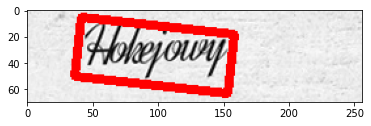

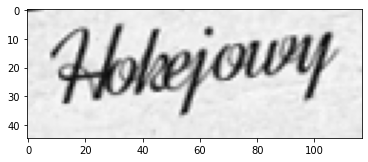

In [13]:
bboxes, image = calc_box(img_path='output/default/00000218.jpg', detector=detector)
boxed = warpBox(image, bboxes[0][0], margin = 0.1)
plt.imshow(keras_ocr.tools.drawBoxes(image, bboxes[0]))
plt.figure()
plt.imshow(boxed)